In [1]:
import numpy as np
from anndata import AnnData
import pandas as pd
import cfp
import pertpy
from rdkit import Chem
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
from cfp import preprocessing as cfpp

/home/icb/leon.stadelmann/miniconda3/envs/cf_test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/icb/leon.stadelmann/miniconda3/envs/cf_test/lib/python3.11/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/home/icb/leon.stadelmann/miniconda3/envs/cf_test/lib/python3.11/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [ ]:
print(pertpy.__version__)

0.10.0


In [ ]:
#output_dir = "/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex"
output_dir = "/ictstr01/home/icb/leon.stadelmann/cellflow/data"

In [ ]:
adata = pertpy.data.combosciplex()

In [ ]:
adata.obs["condition"].value_counts()

condition
Dacinostat+PCI-34051         3298
SRT3025+Cediranib            3016
Givinostat+Cediranib         2783
control+SRT2104              2756
Givinostat+Curcumin          2736
Givinostat+Sorafenib         2734
Givinostat+Carmofur          2692
Givinostat+Crizotinib        2662
Givinostat+Dasatinib         2421
Givinostat+SRT2104           2353
control+Dasatinib            2343
Givinostat+SRT1720           2260
Panobinostat+Curcumin        2244
Cediranib+PCI-34051          2161
Panobinostat+Sorafenib       2013
Panobinostat+SRT2104         1971
Panobinostat+Dasatinib       1955
Dacinostat+Danusertib        1939
Panobinostat+SRT3025         1889
control+Dacinostat           1869
Panobinostat+SRT1720         1826
Panobinostat+PCI-34051       1814
control+Givinostat           1682
Panobinostat+Crizotinib      1641
control+Panobinostat         1578
control+control              1451
Givinostat+Tanespimycin      1310
Dacinostat+Dasatinib         1231
Panobinostat+Alvespimycin     996
cont

In [ ]:
adata.obs["Drug2"].value_counts()

Drug2
Dasatinib       7950
PCI-34051       7273
SRT2104         7080
Cediranib       5799
Curcumin        4980
Sorafenib       4747
Crizotinib      4303
SRT1720         4086
Carmofur        2692
Alvespimycin    2274
Danusertib      1939
SRT3025         1889
Dacinostat      1869
Givinostat      1682
Panobinostat    1578
control         1451
Tanespimycin    1310
Pirarubicin      476
Name: count, dtype: int64

In [ ]:
adata.layers["counts"][0].toarray()

array([[0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
np.unique(adata.X[1].toarray() ,return_counts=True)  

(array([0.       , 2.0676317, 2.6954482, 3.0781522, 3.3542562, 3.5703883,
        3.8987865, 4.0297813, 4.145587 , 4.7139997, 5.0300045, 6.433819 ],
       dtype=float32),
 array([26456,   881,   131,    32,     7,     3,     3,     1,     1,
            1,     1,     1]))

In [ ]:
adata.X = adata.layers["counts"].copy()

In [ ]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [ ]:
adata.layers["counts"]

<Compressed Sparse Column sparse matrix of dtype 'float32'
	with 119553886 stored elements and shape (63378, 27518)>

In [ ]:
sc.pp.highly_variable_genes(adata, inplace=True, n_top_genes=2000)

In [ ]:
adata = adata[:, adata.var["highly_variable"] == True]

In [ ]:
adata.layers["counts"]

<Compressed Sparse Column sparse matrix of dtype 'float32'
	with 10335233 stored elements and shape (63378, 2000)>

In [ ]:
adata.X = adata.layers["counts"].copy()
sc.pp.normalize_total(adata, target_sum=10_000)
sc.pp.log1p(adata)

/home/icb/leon.stadelmann/miniconda3/envs/cf_test/lib/python3.11/site-packages/anndata/_core/anndata.py:617: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/home/icb/leon.stadelmann/miniconda3/envs/cf_test/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:208: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [ ]:
adata.obs["condition"] = adata.obs.apply(
    lambda x: "control" if x["condition"] == "control+control" else x["condition"], axis=1
)

In [ ]:
def rank_genes_groups_by_cov(
    adata,
    groupby,
    control_group,
    covariate,
    n_genes=50,
    rankby_abs=True,
    key_added="rank_genes_groups_cov",
    return_dict=False,
):
    gene_dict = {}
    cov_categories = adata.obs[covariate].unique()
    for cov_cat in cov_categories:
        # name of the control group in the groupby obs column
        control_group_cov = control_group  # "_".join([cov_cat, control_group])
        # subset adata to cells belonging to a covariate category
        adata_cov = adata[adata.obs[covariate] == cov_cat]
        # compute DEGs
        sc.tl.rank_genes_groups(
            adata_cov,
            groupby=groupby,
            reference=control_group_cov,
            rankby_abs=rankby_abs,
            n_genes=n_genes,
            use_raw=False,
        )
        # add entries to dictionary of gene sets
        de_genes = pd.DataFrame(adata_cov.uns["rank_genes_groups"]["names"])
        for group in de_genes:
            gene_dict[group] = de_genes[group].tolist()
    adata.uns[key_added] = gene_dict
    if return_dict:
        return gene_dict


def get_DE_genes(adata):
    adata.obs.loc[:, "control"] = adata.obs.condition.apply(lambda x: 1 if x == "control" else 0)
    adata.obs = adata.obs.astype("category")
    rank_genes_groups_by_cov(
        adata,
        groupby="condition",
        covariate="cell_type",
        control_group="control",
        n_genes=50,
        key_added="rank_genes_groups_cov_all",
    )
    return adata

In [ ]:
adata = get_DE_genes(adata)

/home/icb/leon.stadelmann/miniconda3/envs/cf_test/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:646: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/home/icb/leon.stadelmann/miniconda3/envs/cf_test/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/icb/leon.stadelmann/miniconda3/envs/cf_test/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

In [ ]:
adata.uns["rank_genes_groups_cov_all"].keys()

dict_keys(['Alvespimycin+Pirarubicin', 'Cediranib+PCI-34051', 'Dacinostat+Danusertib', 'Dacinostat+Dasatinib', 'Dacinostat+PCI-34051', 'Givinostat+Carmofur', 'Givinostat+Cediranib', 'Givinostat+Crizotinib', 'Givinostat+Curcumin', 'Givinostat+Dasatinib', 'Givinostat+SRT1720', 'Givinostat+SRT2104', 'Givinostat+Sorafenib', 'Givinostat+Tanespimycin', 'Panobinostat+Alvespimycin', 'Panobinostat+Crizotinib', 'Panobinostat+Curcumin', 'Panobinostat+Dasatinib', 'Panobinostat+PCI-34051', 'Panobinostat+SRT1720', 'Panobinostat+SRT2104', 'Panobinostat+SRT3025', 'Panobinostat+Sorafenib', 'SRT2104+Alvespimycin', 'SRT3025+Cediranib', 'control+Alvespimycin', 'control+Dacinostat', 'control+Dasatinib', 'control+Givinostat', 'control+Panobinostat', 'control+SRT2104'])

In [ ]:
adata.obs["cell_line"] = adata.obs["cell_type"]

In [ ]:
adata.X

<Compressed Sparse Column sparse matrix of dtype 'float32'
	with 10335233 stored elements and shape (63378, 2000)>

In [ ]:
adata_dummy = adata[adata.obs_names.isin(adata.obs.drop_duplicates(subset=["Drug2"]).index)]

In [ ]:
adata_dummy.X

<Compressed Sparse Column sparse matrix of dtype 'float32'
	with 3267 stored elements and shape (18, 2000)>

In [ ]:
drug_to_smiles = {
    "Panobinostat": "CC1=C(C2=CC=CC=C2N1)CCNCC3=CC=C(C=C3)/C=C/C(=O)NO",
    "PCI-34051": "COC1=CC=C(C=C1)CN2C=CC3=C2C=C(C=C3)C(=O)NO",
    "SRT1720": "C1CN(CCN1)CC2=CSC3=NC(=CN23)C4=CC=CC=C4NC(=O)C5=NC6=CC=CC=C6N=C5",
    "SRT3025": "COCCCC1=C(N=C(S1)C2=CC=CC=C2)C(=O)NC3=CC=CC=C3C4=NC5=C(S4)N=CC(=C5)CN6CCCC6",
    "Dacinostat": "C1=CC=C2C(=C1)C(=CN2)CCN(CCO)CC3=CC=C(C=C3)/C=C/C(=O)NO",
    "Sorafenib": "CNC(=O)C1=NC=CC(=C1)OC2=CC=C(C=C2)NC(=O)NC3=CC(=C(C=C3)Cl)C(F)(F)F",
    "Cediranib": "CC1=CC2=C(N1)C=CC(=C2F)OC3=NC=NC4=CC(=C(C=C43)OC)OCCCN5CCCC5",
    "Givinostat": "CCN(CC)CC1=CC2=C(C=C1)C=C(C=C2)COC(=O)NC3=CC=C(C=C3)C(=O)NO",
    "Danusertib": "CN1CCN(CC1)C2=CC=C(C=C2)C(=O)NC3=NNC4=C3CN(C4)C(=O)[C@@H](C5=CC=CC=C5)OC",
    "Dasatinib": "CC1=C(C(=CC=C1)Cl)NC(=O)C2=CN=C(S2)NC3=CC(=NC(=N3)C)N4CCN(CC4)CCO",
    "Tanespimycin": r"C[C@H]1C[C@@H]([C@@H]([C@H](/C=C(/[C@@H]([C@H](/C=C\C=C(\C(=O)NC2=CC(=O)C(=C(C1)C2=O)NCC=C)/C)OC)OC(=O)N)\C)C)O)OC",
    "Carmofur": "CCCCCCNC(=O)N1C=C(C(=O)NC1=O)F",
    "SRT2104": "CC1=C(SC(=N1)C2=CN=CC=C2)C(=O)NC3=CC=CC=C3C4=CN5C(=CSC5=N4)CN6CCOCC6",
    "Crizotinib": "C[C@H](C1=C(C=CC(=C1Cl)F)Cl)OC2=C(N=CC(=C2)C3=CN(N=C3)C4CCNCC4)N",
    "Pirarubicin": "C[C@H]1[C@H]([C@H](C[C@@H](O1)O[C@H]2C[C@@](CC3=C2C(=C4C(=C3O)C(=O)C5=C(C4=O)C(=CC=C5)OC)O)(C(=O)CO)O)N)O[C@@H]6CCCCO6",
    "Alvespimycin": r"C[C@H]1C[C@@H]([C@@H]([C@H](/C=C(/[C@@H]([C@H](/C=C\C=C(\C(=O)NC2=CC(=O)C(=C(C1)C2=O)NCCN(C)C)/C)OC)OC(=O)N)\C)C)O)OC",
    "Curcumin": "COC1=C(C=CC(=C1)/C=C/C(=O)CC(=O)/C=C/C2=CC(=C(C=C2)O)OC)O",
    "control": None,
}

In [ ]:
adata.obs["smiles_drug_1"] = adata.obs["Drug1"].map(drug_to_smiles)
adata.obs["smiles_drug_2"] = adata.obs["Drug2"].map(drug_to_smiles)

In [ ]:
from rdkit.Chem import AllChem


def get_fp(smiles, radius=4, nBits=1024):
    m = Chem.MolFromSmiles(smiles, sanitize=False)
    if m is None:
        return "invalid"
    else:
        try:
            Chem.SanitizeMol(m)
        except:
            return "invalid"
    return AllChem.GetHashedMorganFingerprint(m, radius=radius, nBits=nBits)

In [ ]:
drug_to_fp = {}
for drug, sm in drug_to_smiles.items():
    if not isinstance(sm, str):
        continue
    drug_to_fp[drug] = np.array(list(get_fp(sm)))

[20:37:23] DEPRECATION WARNING: please use MorganGenerator
[20:37:23] DEPRECATION WARNING: please use MorganGenerator
[20:37:23] DEPRECATION WARNING: please use MorganGenerator
[20:37:23] DEPRECATION WARNING: please use MorganGenerator
[20:37:23] DEPRECATION WARNING: please use MorganGenerator
[20:37:23] DEPRECATION WARNING: please use MorganGenerator
[20:37:23] DEPRECATION WARNING: please use MorganGenerator
[20:37:23] DEPRECATION WARNING: please use MorganGenerator
[20:37:23] DEPRECATION WARNING: please use MorganGenerator
[20:37:23] DEPRECATION WARNING: please use MorganGenerator
[20:37:23] DEPRECATION WARNING: please use MorganGenerator
[20:37:23] DEPRECATION WARNING: please use MorganGenerator
[20:37:23] DEPRECATION WARNING: please use MorganGenerator
[20:37:23] DEPRECATION WARNING: please use MorganGenerator
[20:37:23] DEPRECATION WARNING: please use MorganGenerator
[20:37:23] DEPRECATION WARNING: please use MorganGenerator
[20:37:23] DEPRECATION WARNING: please use MorganGenerat

In [ ]:
len(drug_to_fp), len(drug_to_smiles)

(17, 18)

In [ ]:
features_df = pd.DataFrame.from_dict(drug_to_fp).T

In [ ]:
features_df

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
Panobinostat,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
PCI-34051,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
SRT1720,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
SRT3025,0,0,1,0,2,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Dacinostat,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Sorafenib,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
Cediranib,0,0,0,0,2,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1
Givinostat,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Danusertib,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Dasatinib,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
features_cells_drug_1 = np.zeros((adata.shape[0], features_df.shape[1]))
features_cells_drug_2 = np.zeros((adata.shape[0], features_df.shape[1]))
for mol, ecfp in features_df.iterrows():
    print(mol)
    features_cells_drug_1[adata.obs["Drug1"].isin([mol])] = ecfp.values
    features_cells_drug_2[adata.obs["Drug2"].isin([mol])] = ecfp.values

Panobinostat
PCI-34051
SRT1720
SRT3025
Dacinostat
Sorafenib
Cediranib
Givinostat
Danusertib
Dasatinib
Tanespimycin
Carmofur
SRT2104
Crizotinib
Pirarubicin
Alvespimycin
Curcumin


In [ ]:
adata.obsm["ecfp_drug_1"] = features_cells_drug_1
adata.obsm["ecfp_drug_2"] = features_cells_drug_2

In [ ]:
adata_dummy = adata[adata.obs_names.isin(adata.obs.drop_duplicates(subset=["Drug2"]).index)]

In [ ]:
df_conds = adata.obs.drop_duplicates(subset=["condition"])

In [ ]:
at_least_twice = (
    set(df_conds["Drug1"].value_counts()[df_conds["Drug1"].value_counts() >= 2].index)
    | set(df_conds["Drug2"].value_counts()[df_conds["Drug2"].value_counts() >= 2].index)
    | (
        set(df_conds["Drug1"].value_counts()[df_conds["Drug1"].value_counts() >= 1].index).intersection(
            set(df_conds["Drug2"].value_counts()[df_conds["Drug2"].value_counts() >= 1].index)
        )
    )
)

In [ ]:
filtered_df = df_conds[
    (df_conds["Drug1"].isin(at_least_twice)) & (df_conds["Drug2"].isin(at_least_twice))
]

In [ ]:
filtered_df = filtered_df[~((filtered_df["Drug1"]=="control") & (filtered_df["Drug2"]=="control"))]

In [ ]:
filtered_df

,sample,Size_Factor,n.umi,RT_well,Drug1,Drug2,Well,n_genes,n_genes_by_counts,total_counts,...,leiden,condition,pathway1,pathway2,split,control,cell_type,cell_line,smiles_drug_1,smiles_drug_2
Cell,,,,,,,,,,,,,,,,,,,,,
A01_A02_RT_BC_10_Lig_BC_18,sciPlex_theis,0.533816,1433,RT_10,control,Panobinostat,A10,1004,1004,1433.0,...,1,control+Panobinostat,Vehicle,HDAC inhibitor,train,0,A549,A549,None,CC1=C(C2=CC=CC=C2N1)CCNCC3=CC=C(C=C3)/C=C/C(=O)NO
A01_A02_RT_BC_13_Lig_BC_1,sciPlex_theis,1.083277,2908,RT_13,Cediranib,PCI-34051,B1,1896,1895,2907.0,...,0,Cediranib+PCI-34051,EGFR inhibitor,HDAC inhibitor,test,0,A549,A549,CC1=CC2=C(N1)C=CC(=C2F)OC3=NC=NC4=CC(=C(C=C43)...,COC1=CC=C(C=C1)CN2C=CC3=C2C=C(C=C3)C(=O)NO
A01_A02_RT_BC_16_Lig_BC_2,sciPlex_theis,1.298964,3487,RT_16,Givinostat,SRT1720,B4,2154,2152,3485.0,...,0,Givinostat+SRT1720,HDAC inhibitor,Sirtuin inhibitor,train,0,A549,A549,CCN(CC)CC1=CC2=C(C=C1)C=C(C=C2)COC(=O)NC3=CC=C...,C1CN(CCN1)CC2=CSC3=NC(=CN23)C4=CC=CC=C4NC(=O)C...
A01_A02_RT_BC_19_Lig_BC_11,sciPlex_theis,0.587086,1576,RT_19,Panobinostat,SRT3025,B7,1131,1129,1574.0,...,1,Panobinostat+SRT3025,HDAC inhibitor,Sirtuin inhibitor,train,0,A549,A549,CC1=C(C2=CC=CC=C2N1)CCNCC3=CC=C(C=C3)/C=C/C(=O)NO,COCCCC1=C(N=C(S1)C2=CC=CC=C2)C(=O)NC3=CC=CC=C3...
A01_A02_RT_BC_1_Lig_BC_3,sciPlex_theis,2.151281,5775,RT_1,Panobinostat,PCI-34051,A1,3139,3138,5774.0,...,1,Panobinostat+PCI-34051,HDAC inhibitor,HDAC inhibitor,train,0,A549,A549,CC1=C(C2=CC=CC=C2N1)CCNCC3=CC=C(C=C3)/C=C/C(=O)NO,COC1=CC=C(C=C1)CN2C=CC3=C2C=C(C=C3)C(=O)NO
A01_A02_RT_BC_22_Lig_BC_17,sciPlex_theis,0.899999,2416,RT_22,control,Dacinostat,B10,1572,1569,2412.0,...,1,control+Dacinostat,Vehicle,HDAC inhibitor,test,0,A549,A549,None,C1=CC=C2C(=C1)C(=CN2)CCN(CCO)CC3=CC=C(C=C3)/C=...
A01_A02_RT_BC_25_Lig_BC_12,sciPlex_theis,0.534188,1434,RT_25,Dacinostat,PCI-34051,C1,1015,1014,1433.0,...,1,Dacinostat+PCI-34051,HDAC inhibitor,HDAC inhibitor,train,0,A549,A549,C1=CC=C2C(=C1)C(=CN2)CCN(CCO)CC3=CC=C(C=C3)/C=...,COC1=CC=C(C=C1)CN2C=CC3=C2C=C(C=C3)C(=O)NO
A01_A02_RT_BC_28_Lig_BC_12,sciPlex_theis,1.136175,3050,RT_28,Panobinostat,Sorafenib,C4,2015,2015,3050.0,...,1,Panobinostat+Sorafenib,HDAC inhibitor,EGFR inhibitor,train,0,A549,A549,CC1=C(C2=CC=CC=C2N1)CCNCC3=CC=C(C=C3)/C=C/C(=O)NO,CNC(=O)C1=NC=CC(=C1)OC2=CC=C(C=C2)NC(=O)NC3=CC...
A01_A02_RT_BC_31_Lig_BC_2,sciPlex_theis,2.073798,5567,RT_31,Givinostat,Cediranib,C7,3103,3100,5564.0,...,0,Givinostat+Cediranib,HDAC inhibitor,EGFR inhibitor,ood,0,A549,A549,CCN(CC)CC1=CC2=C(C=C1)C=C(C=C2)COC(=O)NC3=CC=C...,CC1=CC2=C(N1)C=CC(=C2F)OC3=NC=NC4=CC(=C(C=C43)...


In [ ]:
condition_not_satisfied = True
rng_seed = 0

def check_condition(df_ood, df_train):
    ood_drugs_1 = set(df_ood["Drug1"])
    ood_drugs_2 = set(df_ood["Drug2"])
    ood_drugs = ood_drugs_1 | ood_drugs_2

    train_drugs_1 = set(df_train["Drug1"])
    train_drugs_2 = set(df_train["Drug2"])
    train_drugs = train_drugs_1 | train_drugs_2

    if ood_drugs.issubset(train_drugs):
        return True
    return False
    
while True:
    rng = np.random.default_rng(rng_seed)
    numbers = np.arange(27)
    rng.shuffle(numbers)
    subset_1 = numbers[:7]
    subset_2 = numbers[7:14]
    subset_3 = numbers[14:21]
    subset_4 = numbers[21:]
    df_1 = filtered_df.iloc[subset_1, :]
    df_2 = filtered_df.iloc[subset_2, :]
    df_3 = filtered_df.iloc[subset_3, :]
    df_4 = filtered_df.iloc[subset_4, :]
    cond_1 = check_condition(df_1, pd.concat((df_2, df_3, df_4)))
    cond_2 = check_condition(df_2, pd.concat((df_1, df_3, df_4)))
    cond_3 = check_condition(df_3, pd.concat((df_1, df_2, df_4)))
    cond_4 = check_condition(df_4, pd.concat((df_1, df_2, df_3)))
    if cond_1+cond_2+cond_3+cond_4 == 4:
        break
    rng_seed +=1
    

In [ ]:
ood_conditions_1 = df_1.condition.values
ood_conditions_2 = df_2.condition.values
ood_conditions_3 = df_3.condition.values
ood_conditions_4 = df_4.condition.values

In [ ]:
adata.obs["ood_1"] = adata.obs.apply(lambda x: x["condition"] if x["condition"] in ood_conditions_1 else "not ood", axis=1)
adata.obs["ood_1"] = adata.obs["ood_1"].astype("category")
adata.obs["ood_2"] = adata.obs.apply(lambda x: x["condition"] if x["condition"] in ood_conditions_2 else "not ood", axis=1)
adata.obs["ood_2"] = adata.obs["ood_2"].astype("category")
adata.obs["ood_3"] = adata.obs.apply(lambda x: x["condition"] if x["condition"] in ood_conditions_3 else "not ood", axis=1)
adata.obs["ood_3"] = adata.obs["ood_3"].astype("category")
adata.obs["ood_4"] = adata.obs.apply(lambda x: x["condition"] if x["condition"] in ood_conditions_4 else "not ood", axis=1)
adata.obs["ood_4"] = adata.obs["ood_4"].astype("category")

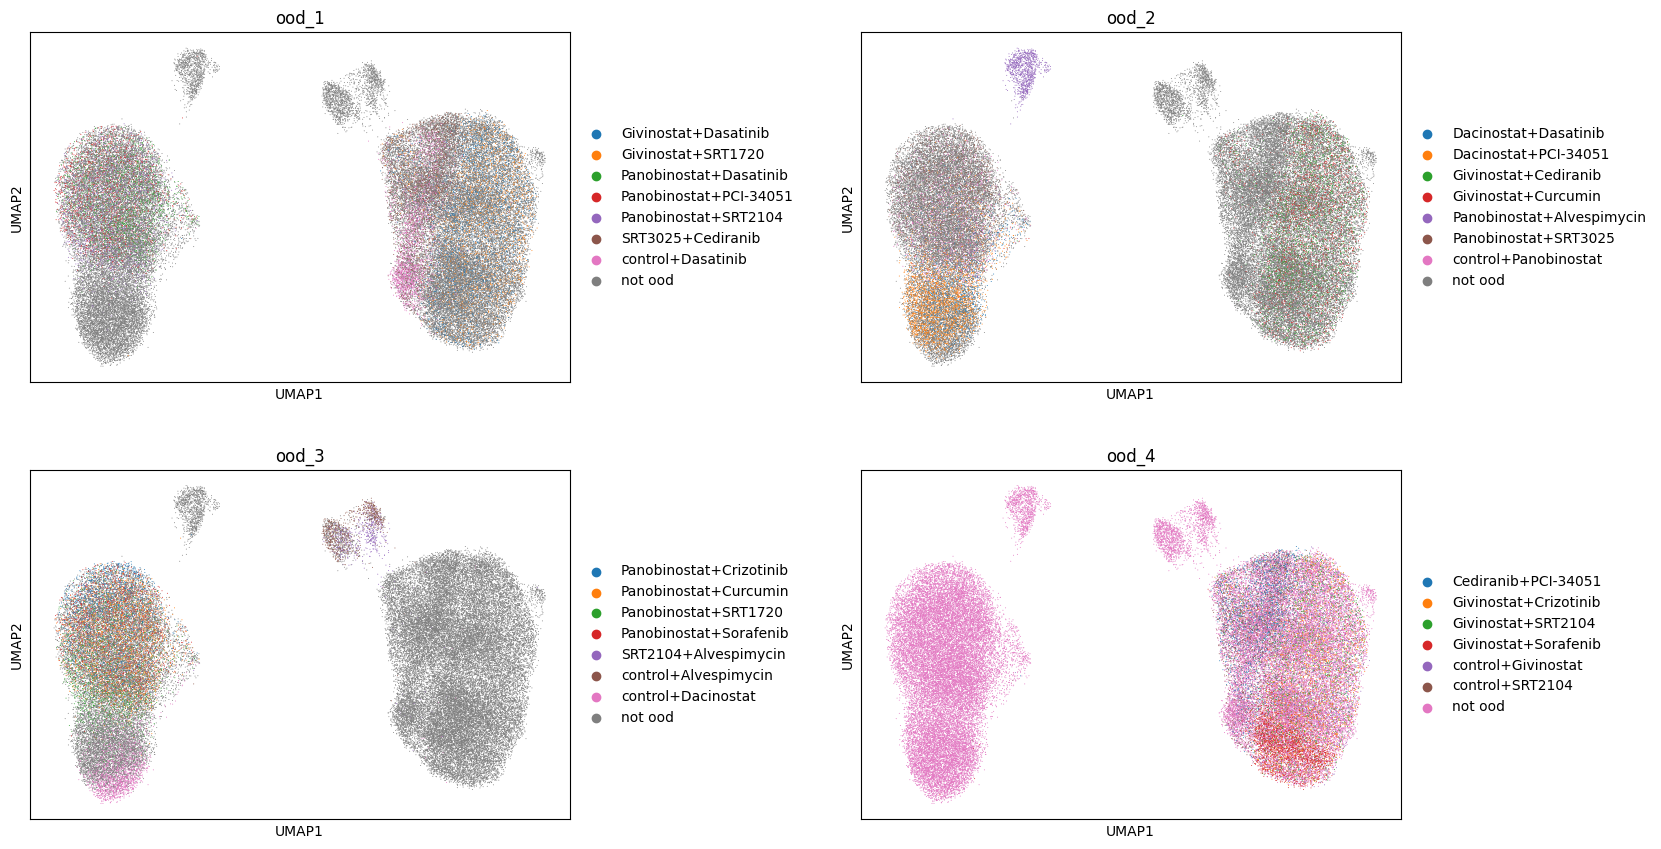

In [ ]:
sc.pl.umap(adata, color=["ood_1", "ood_2", "ood_3", "ood_4"], ncols=2, wspace=.4)

In [ ]:
adata_train_1 = adata[~adata.obs["condition"].isin(ood_conditions_1)].copy()
adata_ood_1 = adata[adata.obs["condition"].isin(ood_conditions_1)].copy()
adata_train_2 = adata[~adata.obs["condition"].isin(ood_conditions_2)].copy()
adata_ood_2 = adata[adata.obs["condition"].isin(ood_conditions_2)].copy()
adata_train_3 = adata[~adata.obs["condition"].isin(ood_conditions_3)].copy()
adata_ood_3 = adata[adata.obs["condition"].isin(ood_conditions_3)].copy()
adata_train_4 = adata[~adata.obs["condition"].isin(ood_conditions_4)].copy()
adata_ood_4 = adata[adata.obs["condition"].isin(ood_conditions_4)].copy()

In [ ]:
adata_train_1.n_obs, adata_train_2.n_obs, adata_train_3.n_obs, adata_train_4.n_obs

(47598, 48867, 52507, 49030)

In [ ]:
def make_splits(adata_train, adata_ood):
    rng = np.random.default_rng(0)
    split_dfs = []
    for drug in adata_train.obs["condition"].unique():
        adata_subset = adata_train[(adata_train.obs["condition"] == drug)]
        n_cells = adata_subset.n_obs
        if drug == "control":
            idx_test = rng.choice(np.arange(n_cells), 500, replace=False)
            remaining_idcs = set(np.arange(n_cells)) - set(idx_test)
            split = ["test" if idx in idx_test else "train" for idx in range(n_cells)]
            df = adata_subset.obs[["condition"]].copy()
            df["split"] = split
            split_dfs.append(df)
        elif n_cells > 300:
            idx_test = rng.choice(np.arange(n_cells), 100, replace=False)
            split = ["test" if idx in idx_test else "train" for idx in range(n_cells)]
            df = adata_subset.obs[["condition"]].copy()
            df["split"] = split
            split_dfs.append(df)
    df_concat = pd.concat(split_dfs, axis=0)
    adata_train.obs["split"] = df_concat[["split"]]
    adata_ood.obs["split"] = "ood"
    adata_train_final = adata_train[adata_train.obs["split"] == "train"]
    adata_test_final = adata_train[adata_train.obs["split"] == "test"]
    adata_ood_final = anndata.concat((adata_ood, adata_test_final[adata_test_final.obs["condition"] == "control"]))

    return adata_train_final, adata_test_final, adata_ood_final

In [ ]:
adata_train_1, adata_test_1, adata_ood_1 =  make_splits(adata_train_1, adata_ood_1)
adata_train_2, adata_test_2, adata_ood_2 =  make_splits(adata_train_2, adata_ood_2)
adata_train_3, adata_test_3, adata_ood_3 =  make_splits(adata_train_3, adata_ood_3)
adata_train_4, adata_test_4, adata_ood_4 =  make_splits(adata_train_4, adata_ood_4)

In [ ]:
cfpp.centered_pca(adata_train_1, n_comps=100)
cfpp.project_pca(query_adata = adata_test_1, ref_adata=adata_train_1)
cfpp.project_pca(query_adata = adata_ood_1, ref_adata=adata_train_1)

cfpp.centered_pca(adata_train_2, n_comps=100)
cfpp.project_pca(query_adata = adata_test_2, ref_adata=adata_train_2)
cfpp.project_pca(query_adata = adata_ood_2, ref_adata=adata_train_2)

cfpp.centered_pca(adata_train_3, n_comps=100)
cfpp.project_pca(query_adata = adata_test_3, ref_adata=adata_train_3)
cfpp.project_pca(query_adata = adata_ood_3, ref_adata=adata_train_3)

cfpp.centered_pca(adata_train_4, n_comps=100)
cfpp.project_pca(query_adata = adata_test_4, ref_adata=adata_train_4)
cfpp.project_pca(query_adata = adata_ood_4, ref_adata=adata_train_4)

/ictstr01/home/icb/leon.stadelmann/cellflow/cell_flow_perturbation/src/cfp/preprocessing/_pca.py:56: ImplicitModificationWarning: Setting element `.varm['X_mean']` of view, initializing view as actual.
  adata.varm["X_mean"] = np.array(X.mean(axis=0).T)
/ictstr01/home/icb/leon.stadelmann/cellflow/cell_flow_perturbation/src/cfp/preprocessing/_pca.py:208: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  query_adata.obsm[obsm_key_added] = np.array(


In [ ]:
'rank_genes_groups_cov_all' in adata_train_1.uns.keys(), 'rank_genes_groups_cov_all' in adata_test_1.uns.keys(), 'rank_genes_groups_cov_all' in adata_ood_1.uns.keys(),

(True, True, False)

In [ ]:
adata_ood_1.uns['rank_genes_groups_cov_all'] = adata_train_1.uns['rank_genes_groups_cov_all']
adata_ood_2.uns['rank_genes_groups_cov_all'] = adata_train_1.uns['rank_genes_groups_cov_all']
adata_ood_3.uns['rank_genes_groups_cov_all'] = adata_train_1.uns['rank_genes_groups_cov_all']
adata_ood_4.uns['rank_genes_groups_cov_all'] = adata_train_1.uns['rank_genes_groups_cov_all']

In [ ]:
adata_train_1.varm["X_mean"] = np.asarray(adata_train_1.varm["X_mean"])
adata_train_2.varm["X_mean"] = np.asarray(adata_train_2.varm["X_mean"])
adata_train_3.varm["X_mean"] = np.asarray(adata_train_3.varm["X_mean"])
adata_train_4.varm["X_mean"] = np.asarray(adata_train_4.varm["X_mean"])

In [ ]:
output_dir

'/ictstr01/home/icb/leon.stadelmann/cellflow/data'

In [ ]:
import os

adata_train_1.write(os.path.join(output_dir, "adata_train_1.h5ad"))
adata_test_1.write(os.path.join(output_dir, "adata_test_1.h5ad"))
adata_ood_1.write(os.path.join(output_dir, "adata_ood_1.h5ad"))

adata_train_2.write(os.path.join(output_dir, "adata_train_2.h5ad"))
adata_test_2.write(os.path.join(output_dir, "adata_test_2.h5ad"))
adata_ood_2.write(os.path.join(output_dir, "adata_ood_2.h5ad"))

adata_train_3.write(os.path.join(output_dir, "adata_train_3.h5ad"))
adata_test_3.write(os.path.join(output_dir, "adata_test_3.h5ad"))
adata_ood_3.write(os.path.join(output_dir, "adata_ood_3.h5ad"))

adata_train_4.write(os.path.join(output_dir, "adata_train_4.h5ad"))
adata_test_4.write(os.path.join(output_dir, "adata_test_4.h5ad"))
adata_ood_4.write(os.path.join(output_dir, "adata_ood_4.h5ad"))


## Train Model

In [ ]:
import functools
from ott.solvers import utils as solver_utils
import optax

In [2]:
def prepare_data(adata_train, adata_test, adata_ood):
    
    adata_tmp =  adata_train[adata_train.obs["Drug1"].drop_duplicates().index]
    ecfp_dict = {drug: adata_tmp[adata_tmp.obs["Drug1"]==drug].obsm["ecfp_drug_1"] for drug in adata_tmp.obs["Drug1"]}

    adata_tmp =  adata_train[adata_train.obs["Drug2"].drop_duplicates().index]
    ecfp_dict.update({drug: adata_tmp[adata_tmp.obs["Drug2"]==drug].obsm["ecfp_drug_2"] for drug in adata_tmp.obs["Drug2"]})

    adata_tmp =  adata_ood[adata_ood.obs["Drug1"].drop_duplicates().index]
    ecfp_dict.update({drug: adata_tmp[adata_tmp.obs["Drug1"]==drug].obsm["ecfp_drug_1"] for drug in adata_tmp.obs["Drug1"]})

    adata_tmp =  adata_ood[adata_ood.obs["Drug2"].drop_duplicates().index]
    ecfp_dict.update({drug: adata_tmp[adata_tmp.obs["Drug2"]==drug].obsm["ecfp_drug_2"] for drug in adata_tmp.obs["Drug2"]})

        
    adata_train.uns['ecfp_rep'] = ecfp_dict
    adata_test.uns['ecfp_rep'] = ecfp_dict
    adata_ood.uns['ecfp_rep'] = ecfp_dict
    return adata_train, adata_test, adata_ood

In [4]:
split = 3
adata_train_path = f"/ictstr01/home/icb/leon.stadelmann/cellflow/data/adata_train_{split}.h5ad"
adata_test_path = f"/ictstr01/home/icb/leon.stadelmann/cellflow/data/adata_test_{split}.h5ad"
adata_ood_path = f"/ictstr01/home/icb/leon.stadelmann/cellflow/data/adata_ood_{split}.h5ad"
adata_train = sc.read_h5ad(adata_train_path)
adata_test = sc.read_h5ad(adata_test_path)
adata_ood = sc.read_h5ad(adata_ood_path)
adata_train, adata_test, adata_ood = prepare_data(adata_train, adata_test, adata_ood)

In [ ]:
cf = cfp.model.CellFlow(adata_train, solver="otfm")

# Prepare the training data and perturbation conditions
perturbation_covariates = {"drugs": ["Drug1", "Drug2"]}
cf.prepare_data(
    sample_rep="X_pca",
    control_key="control",
    perturbation_covariates=perturbation_covariates,
    perturbation_covariate_reps={"drugs": "ecfp_rep"},
)

/ictstr01/home/icb/leon.stadelmann/cellflow/cell_flow_perturbation/src/cfp/data/_datamanager.py:361: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _covariate_data["cell_index"] = _covariate_data.index
100%|██████████| 25/25 [00:08<00:00,  2.99it/s]


In [ ]:
match_fn = functools.partial(
    solver_utils.match_linear,
    epsilon=1.0,
    scale_cost="mean",
    tau_a=1.0,
    tau_b=0.95
)

In [ ]:
optimizer = optax.MultiSteps(optax.adam(1e-4), 20)
flow = {"constant_noise": 1.5}
layers_before_pool = {
    "drugs": [{
        "layer_type": "mlp",
        "dims": [256, 256],
        "dropout_rate": 0.0
    }]
}

layers_after_pool = {
    "drugs": [{
        "layer_type": "mlp",
        "dims": [256, 256],
        "dropout_rate": 0.0
    }]
}

In [ ]:
cf.prepare_model(
    encode_conditions=True,
    condition_embedding_dim=32,
    time_encoder_dims=(1024, 1024, 1024),
    time_encoder_dropout=0.0,
    hidden_dims=(1024, 1024, 1024),
    hidden_dropout=0.0,
    decoder_dims=(1024, 1024, 1024),
    decoder_dropout=0.0,
    pooling="attention_token",
    layers_before_pool=layers_before_pool,
    layers_after_pool=layers_after_pool,
    cond_output_dropout=0.0, #0.9
    time_freqs=1024,
    match_fn=match_fn,
    optimizer=optimizer,
    flow=flow,
    layer_norm_before_concatenation=False,
    linear_projection_before_concatenation=True,
)

In [ ]:
cf.prepare_validation_data(
    adata_test,
    name="test",
    n_conditions_on_log_iteration=2,
    n_conditions_on_train_end=2,
)

cf.prepare_validation_data(
    adata_ood,
    name="ood",
    n_conditions_on_log_iteration=0,
    n_conditions_on_train_end=0,
)

/ictstr01/home/icb/leon.stadelmann/cellflow/cell_flow_perturbation/src/cfp/data/_datamanager.py:361: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _covariate_data["cell_index"] = _covariate_data.index
100%|██████████| 25/25 [00:00<00:00, 336.97it/s]
/ictstr01/home/icb/leon.stadelmann/cellflow/cell_flow_perturbation/src/cfp/data/_datamanager.py:361: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _covariate_data["cell_index"] = _covariate_data.index
100%|██████████| 8/8 [00:00<00:00, 453.35it/s]


In [ ]:
metrics_callback = cfp.training.Metrics(metrics=["r_squared", "mmd", "e_distance"])
decoded_metrics_callback = cfp.training.PCADecodedMetrics(ref_adata=adata_train, metrics=["r_squared", "mmd", "e_distance"])
#wandb_callback = cfp.training.WandbLogger(project="cfp_combosciplex_cellflow", out_dir="/home/icb/leon.stadelmann/tmp", config=config_dict)

In [ ]:
callbacks = [metrics_callback, decoded_metrics_callback] #, wandb_callback]

cf.train(
    num_iterations=30, # 300000
    batch_size=1024,
    callbacks=callbacks,
    valid_freq=10, # 100000
)

 37%|███▋      | 11/30 [00:10<00:17,  1.11it/s]/home/icb/leon.stadelmann/miniconda3/envs/cf_test/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/icb/leon.stadelmann/miniconda3/envs/cf_test/lib/python3.11/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/icb/leon.stadelmann/miniconda3/envs/cf_test/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/icb/leon.stadelmann/miniconda3/envs/cf_test/lib/python3.11/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/icb/leon.stadelmann/miniconda3/envs/cf_test/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty sli

In [ ]:
cf.save("/home/icb/leon.stadelmann/cellflow/data")

In [3]:
cf = cfp.model.CellFlow.load("/home/icb/leon.stadelmann/cellflow/data/CellFlow.pkl")

Use `adata_train`, `adata_test` and `adata_ood` from split 3 as prepared before

In [5]:
adata_ood_ctrl = adata_ood[adata_ood.obs["condition"]=="control"]
adata_test_ctrl = adata_test[adata_test.obs["condition"]=="control"]
adata_ood_ctrl.obs["control"] = True
adata_test_ctrl.obs["control"] = True
covariate_data_ood = adata_ood[adata_ood.obs["condition"]!="control"].obs.drop_duplicates(subset=["condition"])
covariate_data_test = adata_test[adata_test.obs["condition"]!="control"].obs.drop_duplicates(subset=["condition"])

/tmp/ipykernel_2123158/3998593493.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_ood_ctrl.obs["control"] = True
/tmp/ipykernel_2123158/3998593493.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_test_ctrl.obs["control"] = True


In [ ]:
covariate_data_ood

,sample,Size_Factor,n.umi,RT_well,Drug1,Drug2,Well,n_genes,n_genes_by_counts,total_counts,...,split,control,cell_type,cell_line,smiles_drug_1,smiles_drug_2,ood_1,ood_2,ood_3,ood_4
Cell,,,,,,,,,,,,,,,,,,,,,
A01_A02_RT_BC_22_Lig_BC_17,sciPlex_theis,0.899999,2416,RT_22,control,Dacinostat,B10,1572,1569,2412.0,...,ood,0,A549,A549,NaN,C1=CC=C2C(=C1)C(=CN2)CCN(CCO)CC3=CC=C(C=C3)/C=...,not ood,not ood,control+Dacinostat,not ood
A01_A02_RT_BC_28_Lig_BC_12,sciPlex_theis,1.136175,3050,RT_28,Panobinostat,Sorafenib,C4,2015,2015,3050.0,...,ood,0,A549,A549,CC1=C(C2=CC=CC=C2N1)CCNCC3=CC=C(C=C3)/C=C/C(=O)NO,CNC(=O)C1=NC=CC(=C1)OC2=CC=C(C=C2)NC(=O)NC3=CC...,not ood,not ood,Panobinostat+Sorafenib,not ood
A01_A02_RT_BC_4_Lig_BC_15,sciPlex_theis,0.932036,2502,RT_4,Panobinostat,SRT1720,A4,1649,1649,2502.0,...,ood,0,A549,A549,CC1=C(C2=CC=CC=C2N1)CCNCC3=CC=C(C=C3)/C=C/C(=O)NO,C1CN(CCN1)CC2=CSC3=NC(=CN23)C4=CC=CC=C4NC(=O)C...,not ood,not ood,Panobinostat+SRT1720,not ood
A01_A02_RT_BC_52_Lig_BC_32,sciPlex_theis,2.259311,6065,RT_52,Panobinostat,Crizotinib,E4,3262,3260,6063.0,...,ood,0,A549,A549,CC1=C(C2=CC=CC=C2N1)CCNCC3=CC=C(C=C3)/C=C/C(=O)NO,C[C@H](C1=C(C=CC(=C1Cl)F)Cl)OC2=C(N=CC(=C2)C3=...,not ood,not ood,Panobinostat+Crizotinib,not ood
A01_A02_RT_BC_70_Lig_BC_12,sciPlex_theis,1.894990,5087,RT_70,control,Alvespimycin,F10,2801,2800,5086.0,...,ood,0,A549,A549,NaN,C[C@H]1C[C@@H]([C@@H]([C@H](/C=C(/[C@@H]([C@H]...,not ood,not ood,control+Alvespimycin,not ood
A01_A02_RT_BC_73_Lig_BC_11,sciPlex_theis,0.539404,1448,RT_73,Panobinostat,Curcumin,G1,1114,1113,1447.0,...,ood,0,A549,A549,CC1=C(C2=CC=CC=C2N1)CCNCC3=CC=C(C=C3)/C=C/C(=O)NO,COC1=C(C=CC(=C1)/C=C/C(=O)CC(=O)/C=C/C2=CC(=C(...,not ood,not ood,Panobinostat+Curcumin,not ood
A01_A02_RT_BC_79_Lig_BC_57,sciPlex_theis,0.772226,2073,RT_79,SRT2104,Alvespimycin,G7,1459,1456,2070.0,...,ood,0,A549,A549,CC1=C(SC(=N1)C2=CN=CC=C2)C(=O)NC3=CC=CC=C3C4=C...,C[C@H]1C[C@@H]([C@@H]([C@H](/C=C(/[C@@H]([C@H]...,not ood,not ood,SRT2104+Alvespimycin,not ood


: 

In [ ]:
preds_ood = cf.predict(adata=adata_ood_ctrl, sample_rep="X_pca", condition_id_key="condition", covariate_data=covariate_data_ood)

/ictstr01/home/icb/leon.stadelmann/cellflow/cell_flow_perturbation/src/cfp/data/_datamanager.py:361: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _covariate_data["cell_index"] = _covariate_data.index
100%|██████████| 7/7 [00:00<00:00, 261.10it/s]


In [ ]:
import pandas as pd
all_data = []
conditions = []

for condition, array in preds_ood.items():
    all_data.append(array)
    conditions.extend([condition] * array.shape[0])

# Stack all data vertically to create a single array
all_data_array = np.vstack(all_data)

# Create a DataFrame for the .obs attribute
obs_data = pd.DataFrame({
    'condition': conditions
})

# Create the Anndata object
adata_ood_result = anndata.AnnData(X=np.empty((len(all_data_array),2000)), obs=obs_data)
adata_ood_result.obsm["X_pca_pred"] = all_data_array

In [ ]:
cfpp.reconstruct_pca(query_adata=adata_ood_result, use_rep="X_pca_pred", ref_adata=adata_train, layers_key_added="X_recon_pred")

In [ ]:
adata_ood_result.write("/home/icb/leon.stadelmann/cellflow/data/adata_ood_with_predictions_3_attention_seed.h5ad")


In [ ]:
preds_test = cf.predict(adata=adata_test_ctrl, sample_rep="X_pca", condition_id_key="condition", covariate_data=covariate_data_test)

In [ ]:
all_data = []
conditions = []

for condition, array in preds_test.items():
    all_data.append(array)
    conditions.extend([condition] * array.shape[0])

# Stack all data vertically to create a single array
all_data_array = np.vstack(all_data)

# Create a DataFrame for the .obs attribute
obs_data = pd.DataFrame({
    'condition': conditions
})

# Create the Anndata object
adata_test_result = anndata.AnnData(X=np.empty((len(all_data_array),2000)), obs=obs_data)
adata_test_result.obsm["X_pca_pred"] = all_data_array                       

In [ ]:
cfpp.reconstruct_pca(query_adata=adata_test_result, use_rep="X_pca_pred", ref_adata=adata_train, layers_key_added="X_recon_pred")

In [ ]:
adata_test_result.write("/home/icb/leon.stadelmann/cellflow/data/adata_ood_with_predictions_3_attention_seed.h5ad")
